In [55]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [56]:
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
data_dir = os.path.join(root_dir, 'data')
data_file_path = os.path.join(data_dir, 'breast_cancer_data.csv')

df_breast_cancer = pd.read_csv(data_file_path, sep=",", header=0)

# Eliminar espacios adicionales en los nombres de columnas
df_breast_cancer.columns = df_breast_cancer.columns.str.strip()
# Corregir el nombre de 'Reginol Node Positive'
df_breast_cancer.rename(columns={'Reginol Node Positive': 'Regional Node Positive'}, inplace=True)


# EDA (Exploratory Data Analysis)

In [57]:
df_breast_cancer.dtypes

Age                        int64
Race                      object
Marital Status            object
T Stage                   object
N Stage                   object
6th Stage                 object
differentiate             object
Grade                     object
A Stage                   object
Tumor Size                 int64
Estrogen Status           object
Progesterone Status       object
Regional Node Examined     int64
Regional Node Positive     int64
Survival Months            int64
Status                    object
dtype: object

In [58]:
# Missings
df_breast_cancer.isna().sum()

Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
6th Stage                 0
differentiate             0
Grade                     0
A Stage                   0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Regional Node Positive    0
Survival Months           0
Status                    0
dtype: int64

## Univariate Analysis

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import math

def analyze_univariate(df, column_name, axes, idx):
    if df[column_name].dtype in ['int64', 'float64']:
        # Summary statistics
        stats = df[column_name].describe()
        iqr = stats['75%'] - stats['25%'] 

        # Mild Outliers
        mild_ub = stats['75%'] + 1.5 * iqr
        mild_lb = max(stats['25%'] - 1.5 * iqr, 0)

        mild_outliers = np.sum((df[column_name] > mild_ub) | (df[column_name] < mild_lb))
        print("Number of mild outliers in " + column_name + ": ", mild_outliers)

        # Severe Outliers
        severe_ub = stats['75%'] + 3 * iqr
        severe_lb = max(stats['25%'] - 3 * iqr, 0)
        severe_outliers = np.sum((df[column_name] > severe_ub) | (df[column_name] < severe_lb))
        print("Number of severe outliers in " + column_name + ": ", severe_outliers)

        if severe_outliers > 0:
            severe_outlier = df[(df[column_name] > severe_ub) | (df[column_name] < severe_lb)]
            severe_outlier = severe_outlier.sort_values(by=column_name, ascending=False)
            print("\nThe first 5 largest severe outliers in " + column_name + ":")
            print(severe_outlier.head(5))

        # Boxplot
        sns.boxplot(x=df[column_name], ax=axes[idx])
        axes[idx].set_title(f"Boxplot of {column_name}")
        axes[idx].axvline(x=mild_ub, color='orange', linewidth=2, label='Mild Outlier')
        axes[idx].axvline(x=mild_lb, color='orange', linewidth=2)
        axes[idx].axvline(x=severe_ub, color='red', linewidth=2, label='Severe Outlier')
        axes[idx].axvline(x=severe_lb, color='red', linewidth=2)
        axes[idx].legend()

        # Histogram
        sns.histplot(df[column_name], bins=25, kde=True, ax=axes[idx + 1])
        axes[idx + 1].set_title(f"Histogram of {column_name}")

    else:
        # Categorical Data Histogram
        sns.histplot(data=df, x=column_name, discrete=True, ax=axes[idx])
        axes[idx].set_title(f"Distribution of {column_name}")
        axes[idx].tick_params(axis='x', rotation=45)


# Plot all columns in one figure
def plot_all_columns(df):
    num_numerical = df.select_dtypes(include=['int64', 'float64']).shape[1]
    num_categorical = df.select_dtypes(exclude=['int64', 'float64']).shape[1]
    
    total_plots = num_numerical * 2 + num_categorical
    rows = math.ceil(total_plots / 4)-1
    
    fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
    axes = axes.flatten()

    idx = 0
    for col in df.columns:
        if col != 'sev_univar_outlier':
            if df[col].dtype in ['int64', 'float64']:
                analyze_univariate(df, col, axes, idx)
                idx += 2  # Increment by 2 for both boxplot and histogram
            else:
                analyze_univariate(df, col, axes, idx)
                idx += 1  # Increment by 1 for categorical columns

    # Hide unused subplots
    for j in range(idx, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    # Saving the plot
    plot_path = os.path.join(os.pardir, 'plots', 'univ_analysis.png')
    plt.savefig(plot_path, dpi=300)
    plt.show()

In [ ]:
df_breast_cancer["sev_univar_outlier"] = 0
plot_all_columns(df_breast_cancer)

Number of mild outliers in Age:  0
Number of severe outliers in Age:  0
Number of mild outliers in Tumor Size:  222
Number of severe outliers in Tumor Size:  39

The first 5 largest severe outliers in Tumor Size:
      Age   Race Marital Status T Stage N Stage 6th Stage differentiate  \
3965   47  White        Married      T3      N2      IIIA     well diff   
289    41  White        Married      T3      N3      IIIC     poor diff   
1007   60  White       Divorced      T3      N2      IIIA      mod diff   
740    49  White        Married      T3      N1      IIIA      mod diff   
1512   63  White        Married      T4      N2      IIIB      mod diff   

       A Stage  Tumor Size Estrogen Status Progesterone Status  \
3965  Regional         140        Positive            Positive   
289   Regional         140        Positive            Positive   
1007  Regional         140        Positive            Positive   
740   Regional         140        Positive            Positive   
1512  

In [61]:
print(df_breast_cancer[df_breast_cancer["sev_univar_outlier"] > 1])

      Age   Race Marital Status T Stage N Stage 6th Stage  \
238    43  White        Married      T4      N3      IIIC   
633    48  White        Married      T1      N3      IIIC   
3950   47  White        Married      T2      N3      IIIC   

                  differentiate Grade   A Stage  Tumor Size Estrogen Status  \
238       Poorly differentiated     3   Distant         120        Negative   
633       Poorly differentiated     3  Regional          20        Negative   
3950  Moderately differentiated     2  Regional          25        Positive   

     Progesterone Status  Regional Node Examined  Regional Node Positive  \
238             Negative                      28                      26   
633             Negative                      54                      46   
3950            Positive                      60                      19   

      Survival Months Status  sev_univar_outlier  
238                16   Dead                   2  
633                50   Dead   

We remove the `Grade` variable as it gives the same information as the `differentiate`variable.

In [62]:
df_breast_cancer = df_breast_cancer.drop(columns=['Grade'])

## Bivariate Analysis

In [96]:
def bivariate_numerical(df):
    target_variable = 'Status'
    num_vars = df.select_dtypes(include=['int64', 'float64']).columns

    sns.pairplot(df[num_vars.tolist() + [target_variable]], hue=target_variable)
    
    df_melted = df.melt(id_vars=target_variable, value_vars=num_vars)

    # Create a box plot categorized by the categorical variable on the y-axis
    sns.catplot(x='variable', y='value', hue=target_variable, kind='box', data=df_melted, height=6, aspect=2)

    plt.xticks(rotation=45)
    # Saving the plot
    plot_path = os.path.join(os.pardir, 'plots', 'biv_num_analysis.png')
    plt.savefig(plot_path, dpi=300)
    plt.show()

def bivariate_categorical(df):
    target_variable = 'Status'
    cat_vars = df.select_dtypes(include=['object']).columns
    
    # drop status
    cat_vars = cat_vars.drop('Status')
    
    num_plots = len(cat_vars)
    num_cols = 3  # Number of columns in the subplot grid
    num_rows = (num_plots - 1) // num_cols + 1
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    axes = axes.flatten()
    
    for i, cat_var in enumerate(cat_vars):
        if cat_var == 'differentiate':
            df[cat_var] = df[cat_var].replace({"Well differentiated": 'well diff', "Moderately differentiated": 'mod diff', 
                                            "Poorly differentiated": 'poor diff', "Undifferentiated": 'undiff'})
        # Calculate proportions for each category ensuring the sum is 100%
        cat_var_positive = df[df[target_variable] == 'Alive'][cat_var].value_counts(normalize=True) * 100
        cat_var_negative = df[df[target_variable] == 'Dead'][cat_var].value_counts(normalize=True) * 100
        cat_var_positive /= cat_var_positive.sum() / 100
        cat_var_negative /= cat_var_negative.sum() / 100
        classes = pd.Series(df[cat_var].unique())
        
        ax = axes[i]
        index = np.arange(len(classes))
        width = 0.35
        ax.bar(index, cat_var_positive, width, label='Alive')
        ax.bar(index + width, cat_var_negative, width, label='Dead')
        ax.set_xlabel(cat_var)
        ax.set_ylabel('Percentage')
        ax.set_title(f'{cat_var} vs {target_variable}')
        ax.set_xticks(index + width / 2)
        ax.set_xticklabels(classes)
        ax.legend()

    # Hide empty subplots
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    # Saving the plot
    plot_path = os.path.join(os.pardir, 'plots', 'biv_cat_analysis.png')
    plt.savefig(plot_path, dpi=300)
    plt.show()

# def join_barcharts(data1, data2, labels, title='', xlabel='', ylabel='', legend_labels=('Positive', 'Negative')):
    
#     n = len(labels)
#     width = 0.35  # the width of the bars

#     fig, ax = plt.subplots(nrows=3, ncols=3)
#     index = np.arange(n)
#     rects1 = ax.bar(index, data1, width, label=legend_labels[0])
#     rects2 = ax.bar(index + width, data2, width, label=legend_labels[1])

#     ax.set_xlabel(xlabel)
#     ax.set_ylabel(ylabel)
#     ax.set_title(title)
#     ax.set_xticks(index + width / 2)
#     ax.set_xticklabels(labels)
#     ax.legend()

#     return fig, ax

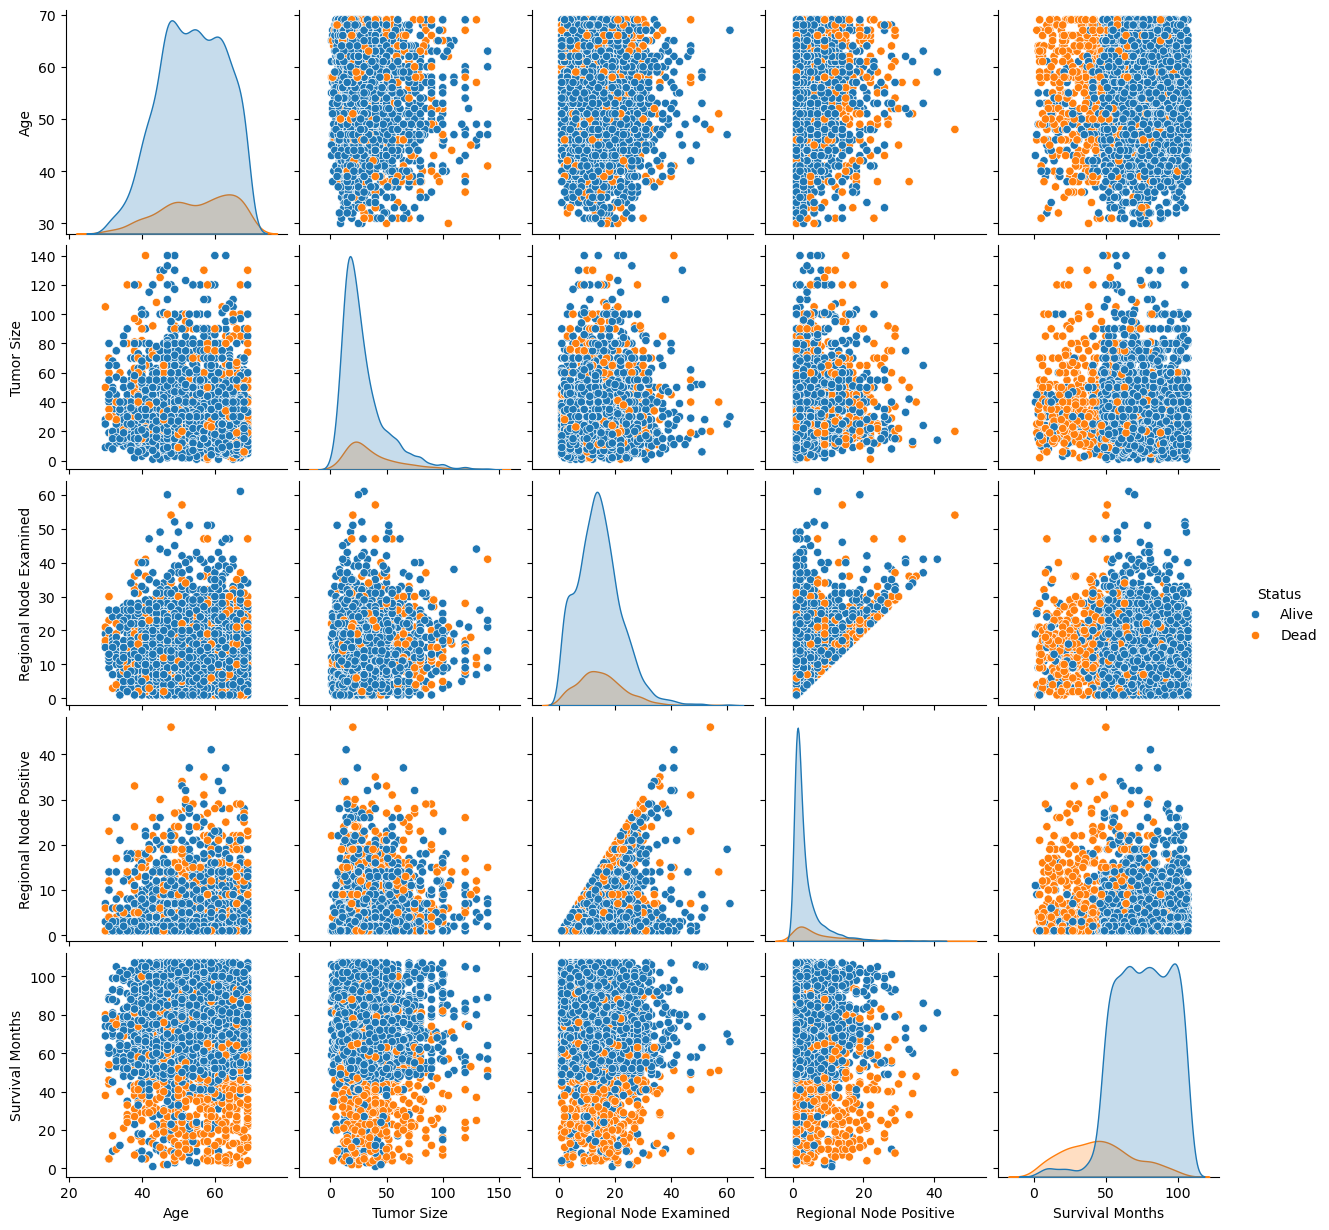

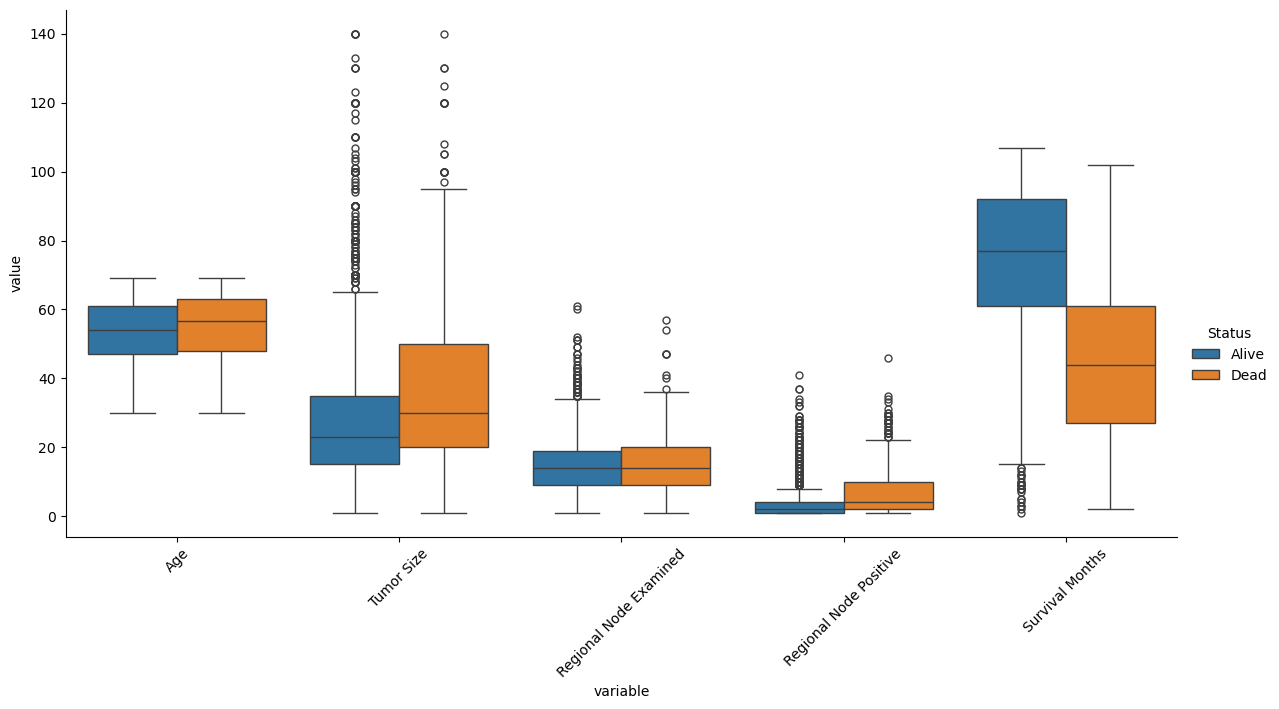

In [97]:
bivariate_numerical(
    df_breast_cancer[['Age', 'Tumor Size', 'Regional Node Examined', 
                      'Regional Node Positive', 'Survival Months', 'Status']]
)

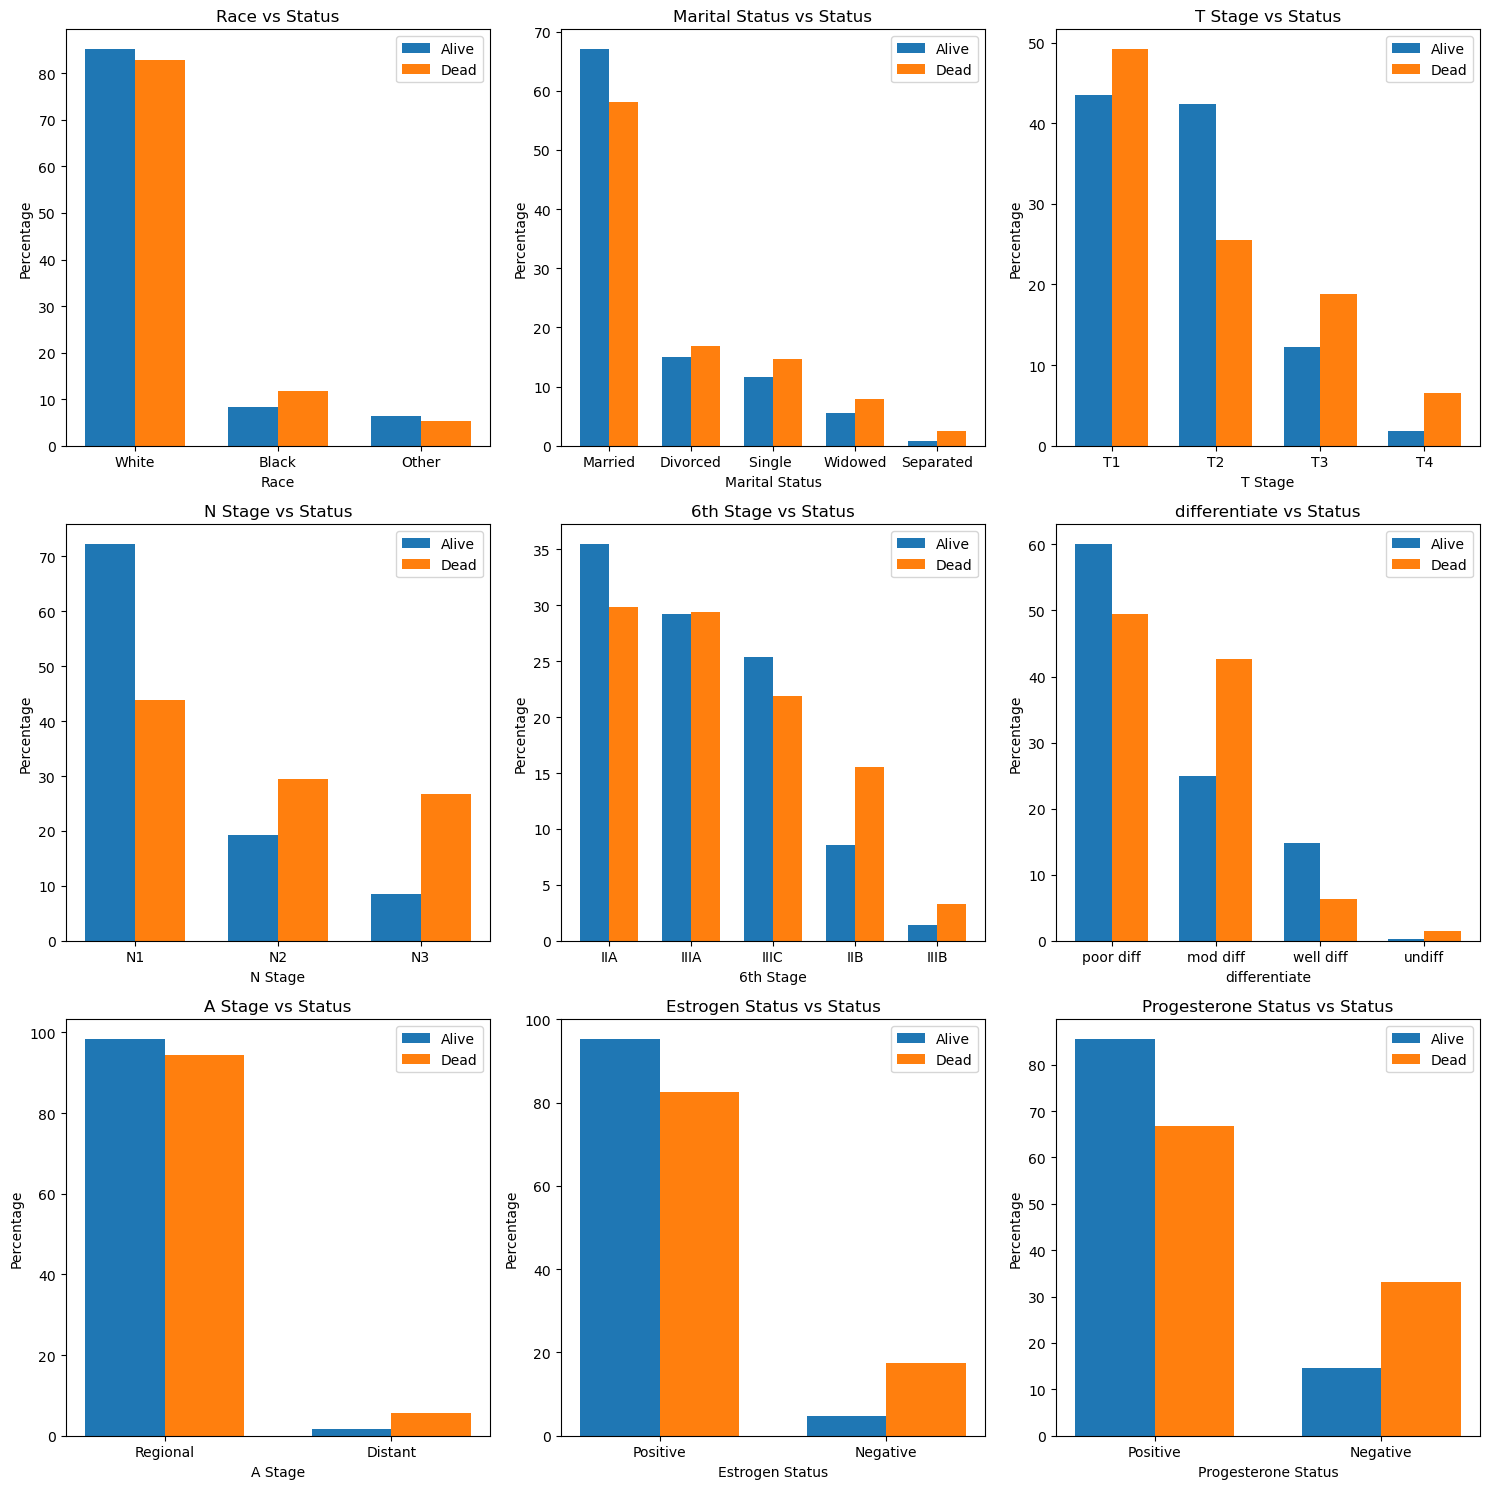

In [98]:
bivariate_categorical(df_breast_cancer)